In [4]:
import polars as pl

pl.Config(float_precision=2)

works_df = pl.read_csv("../data/works.csv", infer_schema_length=10000)
authors_df = pl.read_csv("../data/authors.csv", infer_schema_length=10000)
concerned_works_df = works_df.filter(
    (pl.col("source") == "Evolutionary computation")
    & (pl.col("publication_year") <= 2024)
    & (pl.col("publication_year") >= 2010)
)

In [5]:
citing_works_df = pl.read_csv("../data/citing_works.csv", infer_schema_length=10000)
citing_works_df = citing_works_df.filter(
    (pl.col("reference_id").is_in(concerned_works_df["id"]))
)
citation_count_df = (
    citing_works_df.group_by(pl.col("reference_id"))
    .len("citation_count")
    .sort(by=pl.col("citation_count"), descending=True)[:30]
)

authors_df = pl.read_csv("../data/authors.csv", infer_schema_length=10000)
works_authors_df = pl.read_csv("../data/works_authors.csv", infer_schema_length=10000)
works_authors_df = works_authors_df.filter(
    (pl.col("work_id").is_in(concerned_works_df["id"]))
)
first_authors_df = (
    works_authors_df.filter(pl.col("position") == "first")
    .join(authors_df.with_columns(author_id=pl.col("id")), on="author_id")
    .group_by(pl.col("work_id"))
    .agg(first_authors=pl.col("name").unique().str.concat(", "))
)
middle_authors_df = (
    works_authors_df.filter(pl.col("position") == "middle")
    .join(authors_df.with_columns(author_id=pl.col("id")), on="author_id")
    .group_by(pl.col("work_id"))
    .agg(middle_authors=pl.col("name").unique().str.concat(", "))
)
last_authors_df = (
    works_authors_df.filter(pl.col("position") == "last")
    .join(authors_df.with_columns(author_id=pl.col("id")), on="author_id")
    .group_by(pl.col("work_id"))
    .agg(last_authors=pl.col("name").unique().str.concat(", "))
)

authors_df = (
    first_authors_df.join(middle_authors_df, on="work_id", how="left")
    .join(last_authors_df, on="work_id", how="left")
    .with_columns(
        pl.concat_str(
            [
                pl.col("first_authors"),
                pl.col("middle_authors"),
                pl.col("last_authors"),
            ],
            separator=", ",
            ignore_nulls=True,
        ).alias("authors")
    )
)

top_30_publications_df = (
    citation_count_df.join(
        concerned_works_df.with_columns(reference_id=pl.col("id")), on="reference_id"
    )
    .join(authors_df.with_columns(reference_id=pl.col("work_id")), on="reference_id")
    .sort(by=pl.col("citation_count"), descending=True)
    .select(
        Title=pl.col("title"),
        Authors=pl.col("authors"),
        Year=pl.col("publication_year"),
        TC=pl.col("citation_count"),
        TC_per_year=pl.col("citation_count") / (2024 - pl.col("publication_year")),
    )
    .with_row_index(name="Rank", offset=1)
)
top_30_publications_df.write_csv(
    "../output/top_30_most_cited_publications.csv", float_precision=2
)

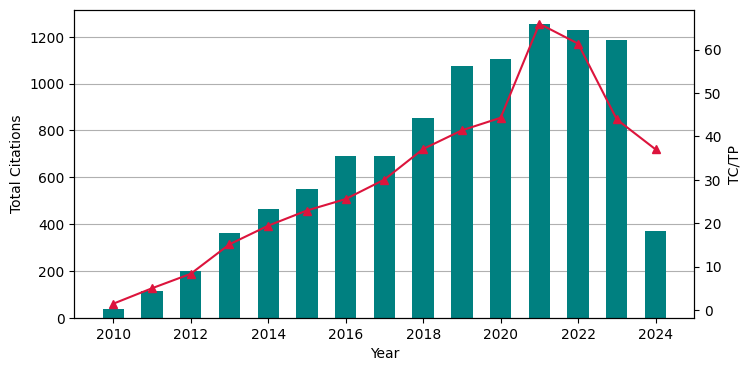

In [6]:
works_authors_count_df = (
    works_authors_df.group_by(pl.col("work_id"))
    .len("author_count")
    .with_columns(pl.col("work_id").alias("id"))
)
concerned_works_with_author_count_df = concerned_works_df.join(
    works_authors_count_df, on="id", how="left"
)
work_citations_df = (
    citing_works_df.group_by("reference_id")
    .len("count")
    .with_columns(
        pl.when(pl.col("count") >= 200).then(1).otherwise(0).alias(">=200"),
        pl.when(pl.col("count") >= 100).then(1).otherwise(0).alias(">=100"),
        pl.when(pl.col("count") >= 50).then(1).otherwise(0).alias(">=50"),
        pl.when(pl.col("count") >= 20).then(1).otherwise(0).alias(">=20"),
        pl.when(pl.col("count") >= 10).then(1).otherwise(0).alias(">=10"),
        pl.when(pl.col("count") >= 5).then(1).otherwise(0).alias(">=5"),
        pl.when(pl.col("count") >= 1).then(1).otherwise(0).alias(">=1"),
    )
)
work_citations_df = work_citations_df.with_columns(pl.col("reference_id").alias("id"))
citing_df = works_df.filter(
    pl.col("id").is_in(citing_works_df["referenced_by"])
    & (pl.col("publication_year") >= 2010)
)
yearly_citations_df = citing_df.group_by(pl.col("publication_year")).len("TC")

concerned_works_with_citations_df = concerned_works_with_author_count_df.join(
    work_citations_df, on="id", how="left"
)
yearly_publications_df = concerned_works_with_citations_df.group_by(
    pl.col("publication_year")
).agg(
    pl.count("id").alias("TP"),
    (pl.col("author_count").sum() / pl.count("id")).alias("AN"),
    pl.col(">=200").sum(),
    pl.col(">=100").sum(),
    pl.col(">=50").sum(),
    pl.col(">=20").sum(),
    pl.col(">=10").sum(),
    pl.col(">=5").sum(),
    pl.col(">=1").sum(),
)
yearly_citations_publication_df = (
    yearly_publications_df.join(yearly_citations_df, on="publication_year", how="left")
    .with_columns((pl.col("TC") / pl.col("TP")).alias("TC/TP"))
    .sort(by=pl.col("publication_year"))
)
yearly_citations_publication_df.write_csv(
    "../output/yearly_citations_publications_authors.csv", float_precision=2
)

yearly_citations_publication_df
import matplotlib.pyplot as plt
# import seaborn as sb

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(yearly_citations_publication_df["publication_year"], yearly_citations_publication_df["TC"], color="teal", width=0.55)
ax2 = ax.twinx()
ax2.plot(yearly_citations_publication_df["publication_year"], yearly_citations_publication_df["TC/TP"], linewidth="1.5", color="crimson", marker="^")
# ax.legend(bbox_to_anchor=(0.08, 0.95), borderaxespad=0)
ax.yaxis.grid(True)
ax.set_axisbelow(True)
ax.set_xlabel("Year")
ax.set_ylabel("Total Citations")
ax2.set_ylabel("TC/TP")
plt.xticks(rotation=45, ha='right')
plt.show()

In [7]:
citing_journals_df = works_df.filter(
    pl.col("id").is_in(citing_works_df["referenced_by"])
    & (pl.col("publication_year") >= 2010)
)

top_journals = (
    citing_journals_df.group_by("source")
    .len("TP")
    .sort(by="TP", descending=True)
    .drop_nulls("source")
    .with_row_index("Rank", offset=1)[:30]
)
topics_df = pl.read_csv("../data/topics.csv")
top_fields = (
    topics_df.filter(
        pl.col("work_id").is_in(citing_journals_df["id"])
        & pl.col("work_id").is_first_distinct()
    )
    .group_by("subfield")
    .len("TP_flds")
    .sort(by="TP_flds", descending=True)
    .with_row_index("Rank", offset=1)[:30]
)
institutions_df = pl.read_csv("../data/institutions.csv")
institutions_df = institutions_df.with_columns(institution_id="id")
works_authors_institutions_df = pl.read_csv("../data/works_authors_institutions.csv")
citing_institutions_df = works_authors_institutions_df.filter(
    pl.col("work_id").is_in(citing_journals_df["id"])
).join(institutions_df, on="institution_id", how="left")
top_institutions = (
    citing_institutions_df.group_by("name")
    .len("TP_inst")
    .sort(by="TP_inst", descending=True)
    .with_row_index("Rank", offset=1)[:30]
)
top_countries = (
    citing_institutions_df.group_by("country_code")
    .len("TP_cntry")
    .sort(by="TP_cntry", descending=True)
    .with_row_index("Rank", offset=1)[:30]
)
top_citers = (
    top_journals.join(top_countries, on="Rank", how="left")
    .join(top_institutions, on="Rank", how="left")
    .join(top_fields, on="Rank", how="left")
)
top_citers.write_csv("../output/top_citers.csv", float_precision=2)

In [8]:
citing_works_df = pl.read_csv("../data/citing_works.csv", infer_schema_length=10000)
citing_works_df = citing_works_df.filter(
    (pl.col("reference_id").is_in(concerned_works_df["id"]))
)
work_citations_df = (
    citing_works_df.group_by("reference_id")
    .len("count")
    .with_columns(
        pl.when(pl.col("count") >= 200).then(1).otherwise(0).alias(">=200"),
        pl.when(pl.col("count") >= 100).then(1).otherwise(0).alias(">=100"),
        pl.when(pl.col("count") >= 50).then(1).otherwise(0).alias(">=50"),
        pl.when(pl.col("count") >= 20).then(1).otherwise(0).alias(">=20"),
        pl.when(pl.col("count") >= 10).then(1).otherwise(0).alias(">=10"),
        pl.when(pl.col("count") >= 5).then(1).otherwise(0).alias(">=5"),
        pl.when(pl.col("count") >= 1).then(1).otherwise(0).alias(">=1"),
    )
)
work_citations_df = work_citations_df.with_columns(
    pl.col("reference_id").alias("work_id")
)

In [9]:
authors_df = pl.read_csv("../data/authors.csv", infer_schema_length=10000)
works_authors_df = pl.read_csv("../data/works_authors.csv", infer_schema_length=10000)
works_authors_df = works_authors_df.filter(
    (pl.col("work_id").is_in(concerned_works_df["id"]))
).with_columns(pl.col("author_id").alias("id")).select("work_id", "id")
works_authors_df = works_authors_df.join(
    authors_df.select("id", "name").filter(pl.col("id").is_first_distinct()),
    on="id",
    how="left",
)
works_authors_df = (
    works_authors_df.join(work_citations_df, on="work_id", how="left")
    .with_columns(cum_count=pl.col("work_id").cum_count().over("id"))
    .sort(by="id")
)
most_productive_authors = (
    works_authors_df.group_by(pl.col("id"))
    .agg(
        pl.col("name").first(),
        pl.count("work_id").alias("TP"),
        pl.col("count").sum().alias("TC"),
        (pl.col("count").sum() / pl.count("id")).alias("TC/TP"),
        pl.col("cum_count")
        .filter(pl.col("count") >= pl.col("cum_count"))
        .len()
        .alias("h"),
        pl.col(">=200").sum(),
        pl.col(">=100").sum(),
        pl.col(">=50").sum(),
        pl.col(">=20").sum(),
        pl.col(">=10").sum(),
        pl.col(">=5").sum(),
        pl.col(">=1").sum(),
    )
    .drop("id")
    .sort(by=pl.col("TP"), descending=True)
    .with_row_index("Rank", offset=1)[:20]
)
most_productive_authors
most_productive_authors.write_csv(
    "../output/most_productive_authors.csv", float_precision=2
)

In [10]:
institutions_df = pl.read_csv("../data/institutions.csv", infer_schema_length=10000)
works_institutions_df = pl.read_csv("../data/works_authors_institutions.csv", infer_schema_length=10000)
works_institutions_df = works_institutions_df.filter(
    (pl.col("work_id").is_in(concerned_works_df["id"]))
).with_columns(pl.col("institution_id").alias("id")).select("work_id", "id")
works_institutions_df = works_institutions_df.join(
    institutions_df.select("id", "name").filter(pl.col("id").is_first_distinct()),
    on="id",
    how="left",
)
works_institutions_df = (
    works_institutions_df.join(work_citations_df, on="work_id", how="left")
    .sort(by="id")
)
most_productive_institutions = (
    works_institutions_df.group_by(pl.col("id"))
    .agg(
        pl.col("name").first(),
        pl.count("work_id").alias("TP"),
        pl.col("count").sum().alias("TC"),
        (pl.col("count").sum() / pl.count("id")).alias("TC/TP"),
        pl.col(">=200").sum(),
        pl.col(">=100").sum(),
        pl.col(">=50").sum(),
        pl.col(">=20").sum(),
        pl.col(">=10").sum(),
        pl.col(">=5").sum(),
        pl.col(">=1").sum(),
    )
    .drop("id")
    .sort(by=pl.col("TP"), descending=True)
    .with_row_index("Rank", offset=1)[:20]
)
most_productive_institutions
most_productive_institutions.write_csv(
    "../output/most_productive_institutions.csv", float_precision=2
)

In [11]:
institutions_df = pl.read_csv("../data/institutions.csv", infer_schema_length=10000)
works_institutions_df = pl.read_csv("../data/works_authors_institutions.csv", infer_schema_length=10000)
works_institutions_df = works_institutions_df.filter(
    (pl.col("work_id").is_in(concerned_works_df["id"]))
).with_columns(pl.col("institution_id").alias("id")).select("work_id", "id")
works_countries_df = works_institutions_df.join(
    institutions_df.select("id", "country_code").filter(pl.col("id").is_first_distinct()),
    on="id",
    how="left",
)
works_countries_df = (
    works_countries_df.join(work_citations_df, on="work_id", how="left")
    .sort(by="id")
)
most_productive_countries = (
    works_countries_df.group_by(pl.col("country_code"))
    .agg(
        pl.count("work_id").alias("TP"),
        pl.col("count").sum().alias("TC"),
        (pl.col("count").sum() / pl.count("id")).alias("TC/TP"),
        pl.col(">=200").sum(),
        pl.col(">=100").sum(),
        pl.col(">=50").sum(),
        pl.col(">=20").sum(),
        pl.col(">=10").sum(),
        pl.col(">=5").sum(),
        pl.col(">=1").sum(),
    )
    .drop("id")
    .sort(by=pl.col("TP"), descending=True)
    .with_row_index("Rank", offset=1)[:20]
)
most_productive_countries
most_productive_countries.write_csv(
    "../output/most_productive_countries.csv", float_precision=2
)

In [12]:
# referenced_works_df = pl.read_csv(
#     "../data/referenced_works.csv", infer_schema_length=10000
# )
# referenced_works_df = (
#     referenced_works_df.filter(
#         (pl.col("referenced_by").is_in(concerned_works_df["id"]))
#     )
#     .group_by("reference_id")
#     .len("citations")
#     .with_columns(pl.col("reference_id").alias("id"))
#     .drop("reference_id")
# )
# referenced_works_in_journals_df = (
#     referenced_works_df.join(works_df, on="id", how="left")
#     .with_columns(pl.col("id").alias("work_id"))
# )
# authors_df = pl.read_csv("../data/authors.csv", infer_schema_length=10000)
# works_authors_df = pl.read_csv("../data/works_authors.csv", infer_schema_length=10000)
# referenced_works_authors_df = (
#     works_authors_df.join(referenced_works_in_journals_df, on="work_id", how="left")
#     .group_by("author_id")
#     .agg(pl.col("citations").sum().alias("Citations_author"))
#     .with_columns(pl.col("author_id").alias("id"))
#     .drop("author_id")
# )

# referenced_works_authors_df = referenced_works_authors_df.join(
#     authors_df.select("id", "name").filter(pl.col("id").is_first_distinct()),
#     on="id",
#     how="left",
# ).select("name", "Citations_author")

# top_referenced_authors = referenced_works_authors_df.sort(
#     by="Citations_author", descending=True
# ).with_row_index("Rank", offset=1)[:10]


# top_referenced_journals = (
#     referenced_works_in_journals_df.group_by("source")
#     .agg(pl.col("citations").sum().alias("Citations_source"))
#     .sort(by="Citations_source", descending=True)
#     .with_row_index("Rank", offset=1)[:10]
# )

# top_referenced_authors_sources = top_referenced_authors.join(
#     top_referenced_journals, on="Rank", how="left"
# )

# top_referenced_authors_sources.write_csv(
#     "../output/top_referenced_authors_sources.csv", float_precision=2
# )

In [13]:
reference_df = pl.read_csv("../data/referenced_works.csv", infer_schema_length=10000)
authors_df = pl.read_csv("../data/authors.csv", infer_schema_length=10000)
works_authors_df = pl.read_csv("../data/works_authors.csv", infer_schema_length=10000)
reference_with_authors_df = (
    reference_df.join(
        works_authors_df.join(
            authors_df.filter(pl.col("id").is_first_distinct())
            .with_columns(pl.col("id").alias("author_id"))
            .drop("id"),
            on="author_id",
        )
        .with_columns(pl.col("work_id").alias("reference_id"))
        .drop("work_id"),
        on="reference_id",
    )
    .with_columns(pl.col("reference_id").alias("id"))
    .drop("reference_id")
)
referenced_works_in_journals_df = (
    reference_with_authors_df.join(works_df, on="id")
    .with_columns(pl.col("id").alias("work_id"))
)

top_referenced_authors = (
    referenced_works_in_journals_df.group_by("author_id")
    .agg(
        pl.col("name").first(),
        pl.struct("id", "referenced_by").unique().count().alias("Citations_authors"),
    )
    .sort(by="Citations_authors", descending=True)
    .filter(pl.col("Citations_authors") >= 10)
)

total_co_cited = (
    referenced_works_in_journals_df.filter(
        pl.col("author_id").is_in(top_referenced_authors["author_id"])
    )
    .group_by("referenced_by")
    .agg((pl.col("author_id")).unique().alias("Links_authors"))
)
referenced_works_in_journals_with_cocitations_df = referenced_works_in_journals_df.join(
    total_co_cited, on="referenced_by"
)
top_referenced_authors = top_referenced_authors.join(
    referenced_works_in_journals_with_cocitations_df.group_by("author_id").agg(
        pl.col("Links_authors").explode().unique().len(),
        (pl.col("Links_authors").list.len()-1).sum().alias("TLS_authors"),
    ),
    on = "author_id"
).drop("author_id").sort(by=pl.col("Citations_authors"), descending=True)

top_referenced_authors.write_csv(
    "../output/top_referenced_authors.csv", float_precision=2
)


top_referenced_sources = (
    referenced_works_in_journals_df.group_by("source")
    .agg(
        pl.struct("id", "referenced_by").unique().count().alias("Citations_sources"),
    )
    .sort(by="Citations_sources", descending=True)
    .filter(pl.col("Citations_sources") >= 5)
)

total_co_cited = (
    referenced_works_in_journals_df.filter(
        pl.col("source").is_in(top_referenced_sources["source"])
    )
    .group_by("referenced_by")
    .agg((pl.col("source")).unique().alias("Links_sources"))
)

referenced_works_in_journals_with_cocitations_df = referenced_works_in_journals_df.join(
    total_co_cited, on="referenced_by"
)

top_referenced_sources = top_referenced_sources.join(
    referenced_works_in_journals_with_cocitations_df.group_by("source").agg(
        pl.col("Links_sources").explode().unique().len()-1,
        (pl.col("Links_sources").list.len()-1).sum().alias("TLS_sources"),
    ),
    on = "source"
).sort(by=pl.col("Citations_sources"), descending=True)

top_referenced_sources.write_csv(
    "../output/top_referenced_sources.csv", float_precision=2
)



top_referenced_authors_sources = top_referenced_authors.with_row_index("Rank", offset=1)[:10].join(
    top_referenced_sources.with_row_index("Rank", offset=1)[:10], on="Rank", how="left"
)

top_referenced_authors_sources.write_csv(
    "../output/top_referenced_authors_sources.csv", float_precision=2
)

In [14]:
reference_df = pl.read_csv("../data/referenced_works.csv", infer_schema_length=10000)
reference_with_authors_df = (
    reference_df.join(
        works_authors_df.join(
            authors_df.filter(pl.col("id").is_first_distinct())
            .with_columns(pl.col("id").alias("author_id"))
            .drop("id"),
            on="author_id",
        )
        .with_columns(pl.col("work_id").alias("reference_id"))
        .drop("work_id"),
        on="reference_id",
    )
    .with_columns(pl.col("reference_id").alias("id"))
    .drop("reference_id")
)
referenced_works_in_journals_df = reference_with_authors_df.join(
    works_df, on="id"
).with_columns(pl.col("id").alias("work_id"))
top_referenced_works = (
    referenced_works_in_journals_df.group_by("id")
    .agg(
        pl.col("title").first(),
        pl.concat_str(
            pl.col("name")
            .filter(pl.col("position") == "first")
            .unique()
            .str.concat(delimiter=", "),
            pl.when(pl.col("id").filter((pl.col("position") == "middle")).len() > 0)
            .then(
                pl.col("name")
                .filter(pl.col("position") == "middle")
                .unique()
                .str.concat(delimiter=", ")
            )
            .otherwise(None),
            pl.when(pl.col("id").filter((pl.col("position") == "last")).len() > 0)
            .then(
                pl.col("name")
                .filter(pl.col("position") == "last")
                .unique()
                .str.concat(delimiter=", ")
            )
            .otherwise(None),
            separator=", ",
            ignore_nulls=True,
            # pl.when(pl.col("id")
            # .filter((pl.col("position") == "middle") | (pl.col("position") == "last")).len() > 0).then(pl.lit("et al.")).otherwise(pl.lit("")),
            # separator=" ",
        ).alias("authors"),
        pl.col("source").first(),
        pl.col("publication_year").first(),
        pl.struct("id", "referenced_by").unique().count().alias("Citations_works"),
    )
    .sort(by="Citations_works", descending=True)
    .filter(pl.col("Citations_works") >= 10)
)
total_co_cited = (
    referenced_works_in_journals_df.filter(
        pl.col("id").is_in(top_referenced_works["id"])
    )
    .group_by("referenced_by")
    .agg((pl.col("id")).unique().alias("Links_works"))
)

referenced_works_in_journals_with_cocitations_df = referenced_works_in_journals_df.join(
    total_co_cited, on="referenced_by"
)

top_referenced_works = (
    top_referenced_works.join(
        referenced_works_in_journals_with_cocitations_df.group_by("id").agg(
            pl.col("Links_works").explode().unique().len() - 1,
            (pl.col("Links_works").list.len() - 1).sum().alias("TLS_works"),
        ),
        on="id",
    )
    .drop("id")
    .sort(by=pl.col("Citations_works"), descending=True)
)
top_referenced_works.write_csv("../output/top_referenced_works.csv", float_precision=2)
top_10_referenced_works = top_referenced_works.with_row_index(name="Rank", offset=1)[
    :10
]
top_10_referenced_works.write_csv(
    "../output/top_10_referenced_works.csv", float_precision=2
)

In [15]:
concerned_works_df.filter(pl.col("title").str.contains("Review"))

id,doi,openalex_url,title,publication_date,publication_year,volume,issue,type,source,source_orginization,source_type,citation_count,reference_count
str,str,str,str,str,i64,str,str,str,str,str,str,i64,i64
"""W2317744239""","""https://doi.or…","""https://openal…","""Particle Swarm…","""2017-03-01""",2017,"""25""","""1""","""review""","""Evolutionary c…","""The MIT Press""","""journal""",557,130
"""W3094858753""","""https://doi.or…","""https://openal…","""A Systematic L…","""2021-03-01""",2021,"""29""","""1""","""article""","""Evolutionary c…","""The MIT Press""","""journal""",29,145
